## Introduction

In this notebook, we perform image classification on the CIFAR-10 dataset using a linear probing approach applied to a pre-trained MobileNet model.
MobileNet is a lightweight and efficient convolutional neural network architecture specifically designed for mobile and embedded vision applications. It uses depthwise separable convolutions to drastically reduce the number of parameters and computational cost compared to standard CNN architectures, while maintaining strong performance.

In this project:
- We load a MobileNet model pre-trained on the ImageNet dataset.
- We remove the original final classification layer.
- We replace it with a new linear (dense) layer suitable for the 10 CIFAR-10 classes.
- We train only the final linear layer while keeping the rest of the model frozen.

Training is performed using PyTorch, and model performance is evaluated using both training and validation accuracy.

### Reference
Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, and Hartwig Adam.  
*MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.*  

In [5]:
import torch
import torchvision.models as models
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Loading and Initialization

First, we load the MobileNetV2 model pre-trained on the ImageNet dataset.


In [6]:
# Load MobileNetV2 model with pre-trained ImageNet weights
weights = MobileNet_V2_Weights.IMAGENET1K_V1
mobilenet = mobilenet_v2(weights=weights)
mobilenet = mobilenet.to(device)
summary(mobilenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

## Data Loading and Preprocessing

In this section, we prepare the CIFAR-10 dataset for input into the MobileNetV2 model. Thus, images are resized from their original 32x32 resolution to 224x224 pixels, matching the input size expected by MobileNetV2.
Furthermore,  images are normalized using the mean and standard deviation values of the ImageNet dataset.


In [7]:
# The transformation applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images from 32x32 to 224x224 (expected by MobileNetV2)
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
        std=[0.229, 0.224, 0.225]    # Normalize using ImageNet standard deviation
    )
])

# ------------------------------------------
# CIFAR-10 Dataset and DataLoaders
# ------------------------------------------

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,                  # Shuffle training data to improve generalization
    num_workers=os.cpu_count(),
    pin_memory=True
)


testloader = DataLoader(
    testset,
    batch_size=64,
    shuffle=False,                  # No need to shuffle test data
    num_workers=os.cpu_count(),
    pin_memory=True
)


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


## Feature Extraction for Linear Probing

To perform linear probing with MobileNetV2, we first extract high-level feature representations from the pre-trained model. For that purpose, we first remove the final classification layer of MobileNetV2 and the remaining network serves as a fixed feature extractor. Both  the training and test sets are passed through the feature extractor and the resulting feature vectors are collected.


In [9]:
# Create a feature extractor by removing the final classification layer from MobileNet
feature_extractor = nn.Sequential(*list(mobilenet.classifier.children())[:-1])  # Remove the last classification layer
mobilenet.classifier = feature_extractor
mobilenet.eval()
mobilenet.to(device)

# Containers to store extracted training features and labels
train_features = []
train_labels = []

# Extract features for the training set
with torch.no_grad():
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        features = mobilenet(images)
        train_features.append(features.cpu())
        train_labels.append(labels)

train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)

# Containers to store extracted test features and labels
test_features = []
test_labels = []

# Extract features for the test set
with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        features = mobilenet(images)
        test_features.append(features.cpu())
        test_labels.append(labels)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 157/157 [00:17<00:00,  8.87it/s]


## Training a Linear Classifier on MobileNetV2 Features

Next, we train a simple linear classifier on the extracted feature representations from MobileNetV2. We use a single fully connected layer is used to map 1280-dimensional feature vectors to the 10 CIFAR-10 classes. The training setup is as follows:
  - Optimizer: Adam with an initial learning rate of 0.001.
  - Learning rate decay: Exponential scheduler with a decay rate of 0.9 after each epoch.
  - Loss function: Cross-entropy loss for multi-class classification.



In [10]:
# Number of epochs
epochs = 50

train_losses = []
train_acc = []
test_losses = []
test_acc = []

# Define a simple linear classifier on top of 1280-dimension MobileNetV2 features
classifier = nn.Linear(1280, 10).to(device)

# Optimizer (Adam) and learning rate scheduler (Exponential decay)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Loss function: Cross-entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Train on entire training set
    for features, labels in trainloader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    # Compute average training loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    train_acc.append(100 * correct / total)

    # Step the learning rate scheduler
    scheduler.step()

    # Evaluation mode for testing
    classifier.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    # Test on entire test set
    with torch.no_grad():
        for features, labels in testloader:
            features, labels = features.to(device), labels.to(device)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()
            test_total += labels.size(0)

    # Compute average test loss and accuracy for the epoch
    avg_test_loss = test_loss / len(testloader)
    test_accuracy = 100 * test_correct / test_total
    test_losses.append(avg_test_loss)
    test_acc.append(test_accuracy)

print("\n=== Final Results After Training ===")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Final Test Loss: {test_losses[-1]:.4f}")
print(f"Final Test Accuracy: {test_acc[-1]:.2f}%")



=== Final Results After Training ===
Final Training Loss: 0.2960
Final Training Accuracy: 90.07%
Final Test Loss: 0.3962
Final Test Accuracy: 86.24%


## Conclusion

After training the linear classifier on top of the extracted MobileNetV2 features for 50 epochs, the final results are summarized below:

| Metric                  | Value          |
|--------------------------|----------------|
| Final Training Loss      | 0.2960          |
| Final Training Accuracy  | 90.07%          |
| Final Test Loss          | 0.3962          |
| Final Test Accuracy      | 86.24%          |


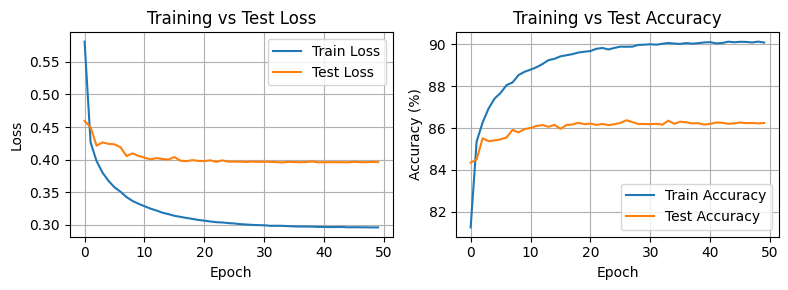

In [11]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
